Carregar as bibliotecas e os dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install liac-arff --quiet

import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

arff_path = '/content/drive/MyDrive/Datasets/diabetes.arff'
with open(arff_path, 'r') as f:
    dataset = arff.load(f)

df = pd.DataFrame(dataset['data'], columns=[a[0] for a in dataset['attributes']])
df['class'] = df['class'].map({'tested_positive': 1, 'tested_negative': 0})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done


Exploração dos dados

In [2]:
print(df.shape)
print(df.describe())
print(df.groupby('class').size())

(768, 9)
             preg        plas        pres        skin        insu        mass  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

             pedi         age       class  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000

Visualização dos dados

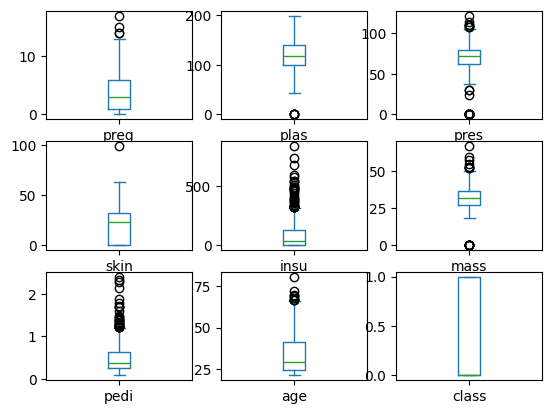

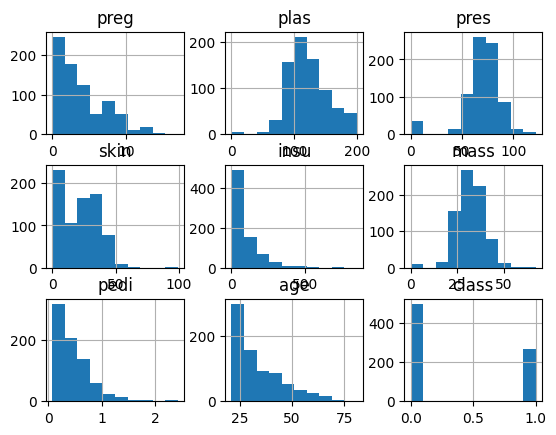

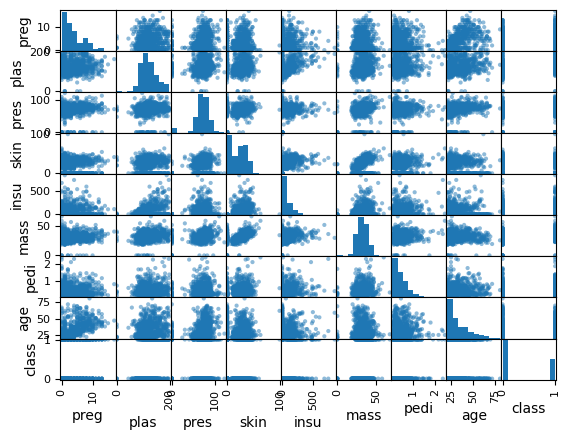

In [3]:
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

df.hist()
plt.show()

scatter_matrix(df)
plt.show()

** Separar treino e validação**

In [4]:
array = df.values
X = array[:, 0:-1]  # Todas as colunas menos a última ('class')
Y = array[:, -1]    # Última coluna ('class')

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_validation.shape)
print(Y_validation.shape)

(614, 8)
(614,)
(154, 8)
(154,)


Treinar e comparar modelos

In [20]:

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)


models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.760947 (0.050121)
LDA: 0.770756 (0.058514)
KNN: 0.710206 (0.049772)
CART: 0.681015 (0.043200)
NB: 0.749418 (0.041042)
SVM: 0.656584 (0.052639)


Comparar os algoritmos

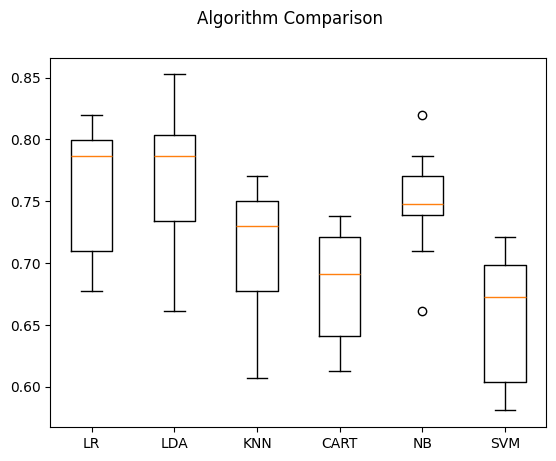

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Avaliar modelos no conjunto de validação

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
predictions = lda.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7922077922077922
[[89  8]
 [24 33]]
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        97
         1.0       0.80      0.58      0.67        57

    accuracy                           0.79       154
   macro avg       0.80      0.75      0.76       154
weighted avg       0.79      0.79      0.78       154



Testamos vários modelos, abaixo as precisões de cada um:


In [25]:

print(f"Precisão Logistic Regression: {acc_lr*100:.2f}%")
print(f"Precisão Decision Tree: {acc_dt*100:.2f}%")
print(f"Precisão Random Forest: {acc_rf*100:.2f}%")
print(f"Precisão Naive Bayes: {acc_nb*100:.2f}%")
print(f"Precisão KNN: {acc_knn*100:.2f}%")
print(f"Precisão SVC: {acc_svc*100:.2f}%")


Precisão Logistic Regression: 79.87%
Precisão Decision Tree: 72.08%
Precisão Random Forest: 76.62%
Precisão Naive Bayes: 75.97%
Precisão KNN: 74.03%
Precisão SVC: 77.27%


O melhor modelo foi o Logistic Regression com precisão de 79.87%

Gerando o joblib

In [26]:
import joblib

# Suponha que seu melhor modelo seja o lda (LinearDiscriminantAnalysis)
# Treinando novamente só para garantir
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)

# Salvar o modelo em um novo arquivo joblib
joblib.dump(lda, '/content/drive/MyDrive/Datasets/modelo_melhor.joblib')

['/content/drive/MyDrive/Datasets/modelo_melhor.joblib']